In [1]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
        
def plot_3_data(subjectID,v_lon_match,HR_final,oxygen_sampling,saveFig=False,syncFigName="null.jpg"):
    fig, ax1 = plt.subplots(figsize=(10, 6))
    plt.title(f"Subject_{subjectID+1} Synchronization",size=20,loc="center",fontdict={'weight': 'bold'},y=1.05)

    ax2 = ax1.twinx()
    ax3 = ax1.twinx()


    ##============ PLOT 3 DATAS
    p1, = ax1.plot(v_lon_match, 'r', label='v_lon_match')
    p2, =ax2.plot(oxygen_sampling,'g',label='oxygen_sampling_5s')
    p3,=ax3.plot(HR_final, 'b', label='HR_sampling')


    ax1.set_xlabel('Index')
    ax1.set_ylabel('v_lon_match', color='r')
    ax1.yaxis.label.set_color(p1.get_color())

    # Create the second plot with secondary y-axis
    ax2.set_ylabel('oxygen_data_reconstruct[:, 1]', color='g')
    ax2.yaxis.label.set_color(p2.get_color())


    # Create the third plot with additional y-axis on the right side
    ax3.spines["right"].set_position(("axes", 1.2))
    make_patch_spines_invisible(ax3)
    ax3.spines["right"].set_visible(True)
    ax3.set_ylabel('Heart rate')
    ax3.yaxis.label.set_color(p3.get_color())
    ax3.yaxis.tick_right()
    ax3.yaxis.set_label_position('right')


    # Adjust spacing between subplots
    fig.tight_layout()

    tkw = dict(size=4, width=1.5)
    ax1.tick_params(axis='y',colors=p1.get_color(),**tkw)
    ax2.tick_params(axis='y',colors=p2.get_color(),**tkw)
    ax3.tick_params(axis='y',colors=p3.get_color(),**tkw)

    ax1.spines[['top']].set_visible(False)
    ax2.spines[['top']].set_visible(False)
    ax3.spines[['top']].set_visible(False)
    

    if saveFig:
        fig = plt.gcf()
        fig.set_size_inches(16, 12)
        syncFigName=plt.savefig(syncFigName)
    # Show the plot
#     plt.show()

20


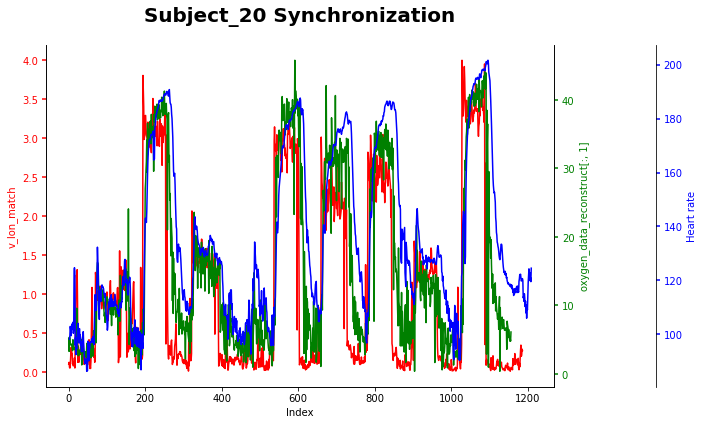

In [9]:
# DEFINE SUBJECT ID HERE
usedSubjects=[1,2,3,4,5,6,7,8,9,10,11,12,13,16,19,20]

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.io


GaitPod_CutOff_Times = [565, 358, 318, 672, 700, 660, 594, 280, 533, 365, 474, 1549, 530, -1, -1, 387, -1, -1, 375, 350];
HR_CutOff_Times = [519, 530, 409, 505, 450, 502, 490, 430, 528, 546, 365, 712, 401, -1, -1, 390, -1, -1, 387, 410];

## CUTOFF INDEX FOR SUBJECT 1
sliceIdx1=200
sliceIdx2=370
sliceIdx3=559
sliceIdx4=750

# Sampling time for heart rate (in seconds)
HR_sampling_time=5

# Sampling time for oxygen (in seconds)
Oxygen_sampling_time=5

# Sampling time for gaitpod (in seconds)
GaitPod_sampling_time=5

# DIRECTORY FOR DATA FILES
HR_dir="HR data/"
oxygen_dir="OxyCon data/"
gaitpod_dir="GaitPod data/"


def readCSV(fileName):
    res=np.array(pd.read_csv(fileName,header=None,delimiter='\t'))
    return res


def readTXT(fileName):
    res=np.array(pd.read_csv(fileName,header=None,delimiter='\t'))
    return res


def comma_to_float(string):
    string=str(string)
    if len(string) == 0 or '-' in string or '#' in string:
        return -100
    # Replace comma with dot and convert to float
    if ',' in string:
        return np.float32(string.replace(',', '.'))
    else:
        return np.float32(string)

    
def oxygen_processing(subjectID,oxygenFn,Oxygen_sampling_time):
    """
    @desribe: Function to process oxygen file
    @params
    - oxygenFn: Oxygen file name
    - Oxygen_sampling_time: (in seconds) sampling time of oxygen, default 5 seconds
    
    @return
    - oxygen_sampling: Oxygen value after interpolation
    """
    
    oxygen_data=np.array(np.squeeze(pd.read_csv(oxygenFn,header=6,delimiter='\t')))
    oxygen_data_reconstruct=np.zeros(np.shape(oxygen_data))
    iter=0

    for row in oxygen_data:
        oxygen_data_reconstruct[iter][0]=row[0]
        oxygen_data_reconstruct[iter][1]=comma_to_float(row[1])
        iter+=1
    
    # REMOVE OXYGEN OUTLINE, IF ANY
    outline_threshold=200
    for i,row in enumerate(oxygen_data_reconstruct):
        if row[1]>outline_threshold:
            oxygen_data_reconstruct=np.delete(oxygen_data_reconstruct,i,0)
            
    # REMOVE MISSING DATA FROM CSV FILE
    mask=oxygen_data_reconstruct[:, 1] >= 0
    oxygen_data_reconstruct=oxygen_data_reconstruct[mask]
    
    # INTERPOLATE OXYGEN DATA
    timestamps=oxygen_data_reconstruct[:,0]    
    firstSec=timestamps[0]
    lastSec=timestamps[-1]

    oxygenResamplingIdx = np.arange(firstSec, lastSec, Oxygen_sampling_time)
    oxygen_sampling=np.interp(oxygenResamplingIdx,timestamps,oxygen_data_reconstruct[:,1])

    ## ===== FOR SUBJECT 2, REMOVE NAN AND ZERO ENTRIES
    reconstruct_index=[]
    if subjectID==1:
        for i,data in enumerate(oxygen_sampling):
            if data < 1:
                reconstruct_index.append(i)
#         print(reconstruct_index)
        oxygen_sampling = [value for index,value in enumerate(oxygen_sampling) if index not in reconstruct_index]
    
    return oxygen_sampling,reconstruct_index

def heart_rate_processing(subjectID,HRFn,HR_sampling_time,reconstruct_index):
    """
    
    """
    HR_CutOff_Time=HR_CutOff_Times[subjectID]
    HR_data=np.squeeze(readCSV(HRFn))
    HR_data_stack=list()
    for i in range(len(HR_data)):
        HR_data_tmp=HR_data[i].split(";")
        HR_data_stack.append(HR_data_tmp)
    HR_data_stack=np.vstack(HR_data_stack)
    
    arr_list=HR_data_stack.tolist()
    HR_data_stack=[item for item in arr_list if len(item[0]) > 0 and len(item[1]) > 0]
    HR_data_stack=np.array(HR_data_stack).astype(np.float32).squeeze()
    HR_data_stack[:,0]=HR_data_stack[:,0]/1000
    
    # INTERPOLATE HEART RATE DATA
    HRFirstEle=HR_data_stack[0,0]
    HRLastEle=HR_data_stack[-1,0]
    HR_sampling_index=np.arange(HRFirstEle, HRLastEle, HR_sampling_time)
    HR_sampling=np.interp(HR_sampling_index,HR_data_stack[:,0],HR_data_stack[:,1])
    
    # CUT OFF HR data
    HR_sampling_cut=HR_sampling[HR_CutOff_Time:]
    HR_remove_index=[]
    
    if subjectID==1:
        for idx,hr_data_tmp in enumerate(HR_sampling_cut):
            if hr_data_tmp < 70:
                HR_remove_index.append(idx)
                
        HR_sampling_cut=[value for index,value in enumerate(HR_sampling_cut) if index not in HR_remove_index ]
        HR_sampling_cut=np.array([value for index,value in enumerate(HR_sampling_cut) if index not in reconstruct_index])
        data=pd.Series(HR_sampling_cut)
        data[229:230] = data[578:585] = data[835:862] = data[953:962] = None
        data_interpolated=data.interpolate(method='polynomial',order=2)
        percentChangeData=data_interpolated.pct_change()
        rollingStd=percentChangeData.rolling(10).std()

        eps_values = np.random.uniform(0, 1, size=(230 - 229,))
        data_interpolated[229:230] = (rollingStd[228] * eps_values + 1) * data_interpolated[229:230]

        eps_values = np.random.uniform(0, 1, size=(585 - 578,))
        data_interpolated[578:585] = (rollingStd[577] * eps_values + 1) * data_interpolated[578:585]

        eps_values = np.random.uniform(0, 1, size=(862 - 835,))
        data_interpolated[835:862] = (rollingStd[834] * eps_values + 1) * data_interpolated[835:862]

        eps_values = np.random.uniform(0, 1, size=(962 - 953,))
        data_interpolated[953:962] = (rollingStd[952] * eps_values + 1) * data_interpolated[953:962]
        
        HR_final=data_interpolated
    
    elif subjectID in [3,8]:
        HR_final=pd.DataFrame(HR_sampling_cut).rolling(5).mean()
    
    else:
        HR_final=pd.DataFrame(HR_sampling_cut).rolling(3).mean()
        
    return HR_final


def gaitpod_processing(subjectID,GaitPodFn,GaitPod_sampling_time,reconstruct_index):
    
    gaitpod_data = scipy.io.loadmat(GaitPodFn)
    v_lon=gaitpod_data['V_lon']
    v_d=gaitpod_data['v_d']

    gaitpod_CutOff_Time=GaitPod_CutOff_Times[subjectID]
    gp_new_idx=gaitpod_CutOff_Time*400

    # Remove NaN data from v_lon and v_d
    if (np.isnan(v_d).any() or np.isnan(v_lon).any()):
        v_lon=v_lon[~np.isnan(v_lon)]
        v_d=v_d[~np.isnan(v_d)]

    # Cut off gaitpod data
    v_lon=v_lon[gp_new_idx:,:]
    v_d=v_d[gp_new_idx:,:]

    N=len(v_lon)
    idx=np.arange(0,N,400*GaitPod_sampling_time)

    v_lon_match = pd.DataFrame(v_lon, index = None)
    v_lon_match = v_lon_match.rolling(400).mean()
    v_lon_match=v_lon_match.iloc[idx].values
    v_lon_match=v_lon_match[1:]

    v_d_match = pd.DataFrame(v_d)
    v_d_match = v_d_match.rolling(400).mean()
    v_d_match=v_d_match.iloc[idx].values
    v_d_match=v_d_match[1:]
    
    if subjectID==1:
        v_lon_match=np.array([value for index,value in enumerate(v_lon_match) if index not in reconstruct_index])
        v_d_match=np.array([value for index,value in enumerate(v_d_match) if index not in reconstruct_index])
        
    return v_lon_match, v_d_match


def cut_and_concatenate(subjectID,v_lon_match,HR_final,oxygen_sampling):
    
    if subjectID==0:
        v_lon_match_1 = v_lon_match[:sliceIdx1]
        HR_final_1 = HR_final[:sliceIdx1]
        oxygen_sampling_1=oxygen_sampling[:sliceIdx1]
    
        v_lon_match_2=v_lon_match[sliceIdx2:sliceIdx3]
        HR_final_2=HR_final[sliceIdx2:sliceIdx3]
        oxygen_sampling_2=oxygen_sampling[sliceIdx2:sliceIdx3]

        v_lon_match_3=v_lon_match[sliceIdx4:]
        HR_final_3=HR_final[sliceIdx4:]
        oxygen_sampling_3=oxygen_sampling[sliceIdx4:]
    
        v_lon_match=np.concatenate([v_lon_match_1,v_lon_match_2,v_lon_match_3])
        HR_final=np.concatenate([HR_final_1,HR_final_2,HR_final_3])
        oxygen_sampling=np.concatenate([oxygen_sampling_1,oxygen_sampling_2,oxygen_sampling_3])

    if subjectID==9:
        sliceIdx1_10=520
        sliceIdx2_10=700

        oxygen_sampling_1=oxygen_sampling[:sliceIdx1_10]
        v_lon_match_1 = v_lon_match[:sliceIdx1_10]
        HR_final_1 = HR_final[:sliceIdx1_10]
        
        v_lon_match=v_lon_match_1
        HR_final=HR_final_1
        oxygen_sampling=oxygen_sampling_1
    
    return v_lon_match,HR_final,oxygen_sampling
        
        
# Subject ID same as excel
def get_data_frame(subjectID):
    
    """
    @subjectID: ID of subject same as excel file [0,20]
    """
    print(subjectID)
    subjectID=subjectID-1
    i=subjectID
    Fn=f"OK00{i+1}" if i < 9 else f"OK0{i+1}"

    GaitPodFn=Fn+"_vel_imu.mat"
    HRFn=Fn+"_HR.csv"
    oxygenFn=Fn+"_Oxycon.txt"

    HRFn=HR_dir+HRFn
    oxygenFn=oxygen_dir+oxygenFn
    GaitPodFn=gaitpod_dir+GaitPodFn
    
    
    oxygen_sampling,reconstruct_index=oxygen_processing(subjectID,oxygenFn,Oxygen_sampling_time)
    HR_final=heart_rate_processing(subjectID,HRFn,HR_sampling_time,reconstruct_index)
    v_lon_match, v_d_match = gaitpod_processing(subjectID,GaitPodFn,GaitPod_sampling_time,reconstruct_index)
    
    if subjectID in [0,9]:
        v_lon_match,HR_final,oxygen_sampling=cut_and_concatenate(subjectID,v_lon_match,HR_final,oxygen_sampling)
    
    plot_3_data(subjectID,v_lon_match,HR_final,oxygen_sampling)

    
usedSubjects=[1,2,3,4,5,6,7,8,9,10,11,12,13,16,19,20]

# for i in usedSubjects:
get_data_frame(20)